# 📂 Giriş

Bu ödev kapsamında **Telco Customer Churn** veri setiyle çalıştım. Amacım, bir telekomünikasyon şirketinin müşteri kaybını etkileyen faktörleri analiz ederek, veriyi modellemeye hazır hale getirmekti. Veri setinde müşterilere ait demografik bilgiler, hizmet kullanımları ve fatura detayları yer alıyor.

Çalışmaya başlamadan önce veriyi detaylıca inceledim. Özellikle:
- Sayısal türde olması gereken sütunları dönüştürdüm,
- Eksik değerleri kontrol ederek uygun şekilde yönettim,
- Ve veri setine anlam katacak yeni değişkenler türettim.

Bu süreçte en çok dikkat ettiğim noktalar; **veri temizliği**, **eksik değerlerin yönetimi** ve **özellik mühendisliği** oldu. Böylece veri setini makine öğrenmesi için daha anlamlı ve güçlü hale getirdim.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Gerekli kütüphaneleri import edelim.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ml/5_hafta/datasets/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# 1. 📊 Veriyi İncele ve Hazırla

In [ ]:
# TotalCharges sütununu sayısal değere çeviriyoruz
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Churn sütunu genelde 'Yes' ve 'No' şeklinde kategorik olur. Makine öğrenmesinde sayısal olması için şöyle dönüştürüyoruz:

In [ ]:
# Churn sütununu binary (1-0) yapıyoruz
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


'Yes' için 1 ve 'No' için 0

TotalCharges sütununda eksik değerler olabilir çünkü biraz önce dönüştürme sırasında NaN olmuş olabilir. Bu yüzden eksik değerleri kontrol edip basitçe ortalama ile doldurabiliriz:

In [ ]:
# Eksik değerleri kontrol edelim
print(df.isnull().sum())


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


TotalCharges sütununda düşündüğümüz gibi eksik değerler var. Bunları dolduralım

In [ ]:
# Eksik TotalCharges değerlerini ortalama ile dolduruyoruz
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


<ipython-input-20-32318c8f7415>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


Tekrar kontol ettiğimizde artık eksik değerlerimizin olmadığını görüyoruz.

Sıradaki adımımız yeni değişkenler üretmek.

Analize katkı sağlayacağını düşündüğüm 4 adet yeni değişken üretmeye karar verdim Bunlar sırasıyla:

1. **AverageCharges**
Aylık ortalama ücret (Toplam ücret / Ay sayısı)

2. **IsSenior**
SeniorCitizen sütununa göre 1 (senior) ve 0 (değil) şeklinde işaretleme

3. **HasMultipleLines**
'MultipleLines' sütununda 'No phone service' veya 'No' olanları 0, diğerlerini 1 olarak işaretleme

4. **IsPartnerOrDependent**
Eğer müşteri hem Partner hem Dependent ise 1, değilse 0

In [ ]:
df['AverageCharges'] = df['TotalCharges'] / df['tenure']
df['AverageCharges'] = df.apply(lambda row: row['TotalCharges']/row['tenure'] if row['tenure'] > 0 else 0, axis=1)#tenure 0 olanlar için hata almamak amacıyla

df['IsSenior'] = df['SeniorCitizen'].apply(lambda x: 1 if x == 1 else 0)

df['HasMultipleLines'] = df['MultipleLines'].apply(lambda x: 1 if x == 'Yes' else 0)

df['IsPartnerOrDependent'] = df.apply(lambda row: 1 if (row['Partner'] == 'Yes' and row['Dependents'] == 'Yes') else 0, axis=1)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AverageCharges,IsSenior,HasMultipleLines,IsPartnerOrDependent
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,0,29.850000,0,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,0,55.573529,0,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,1,54.075000,0,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,0,40.905556,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,1,75.825000,0,0,0


Bu adımda:

Veriyi sayısallaştırdık,

Eksikleri yönettik,

Yeni anlamlı değişkenler ürettik.

## 📐 2. Veriyi Ayırma

Bu aşamada veri setini **özellikler (X)** ve **hedef değişken (y)** olarak ikiye ayırdım.  
Hedef değişkenimiz: **Churn (1 = müşteri kaybı, 0 = kayıp yok).**

Özellikler: Churn dışındaki tüm sütunlar olacak.  
Bu ayrım, makine öğrenmesi modellerini eğitirken gerekli.


In [ ]:
# Özellikler (X) ve hedef değişken (y) belirleyelim

X = df.drop('Churn', axis=1)
y = df['Churn']

# Kontrol edelim
print("X (özellikler) boyutu:", X.shape)
print("y (hedef) boyutu:", y.shape)


X (özellikler) boyutu: (7043, 24)
y (hedef) boyutu: (7043,)


Bu aşamada veri setini daha iyi anlamak için bazı temel görselleştirmeler yaptım:
1. Churn dağılımını inceledim,
2. Sayısal sütunların genel dağılımını analiz ettim,
3. Churn durumuna göre bazı önemli değişkenleri karşılaştırdım.

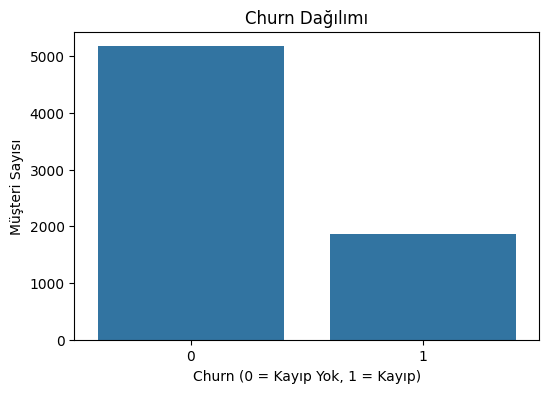

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn dağılımı
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Dağılımı')
plt.xlabel('Churn (0 = Kayıp Yok, 1 = Kayıp)')
plt.ylabel('Müşteri Sayısı')
plt.show()


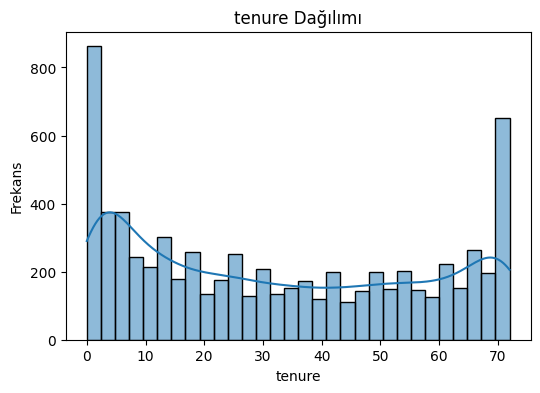

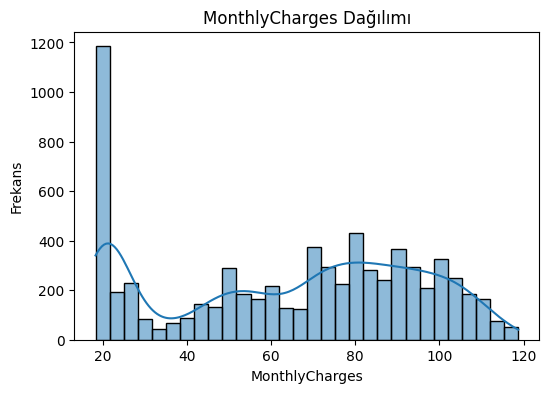

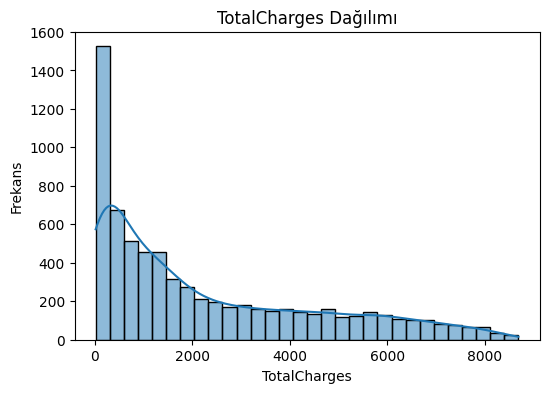

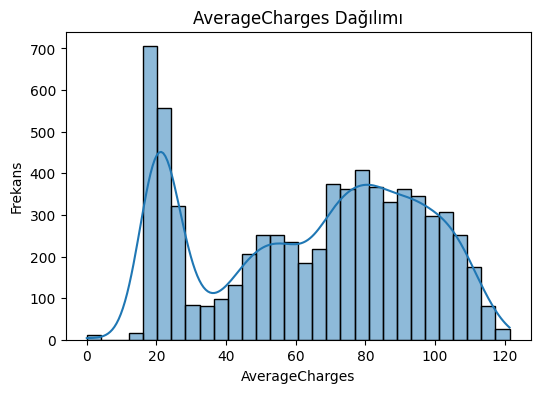

In [ ]:
# Numerik değişkenlerden birkaçını inceleyelim
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AverageCharges']

for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'{col} Dağılımı')
    plt.xlabel(col)
    plt.ylabel('Frekans')
    plt.show()


Artık X ve y hazır. Bir sonraki aşamada modeli eğitmek için eğitim ve test kümelerine böleceğim.


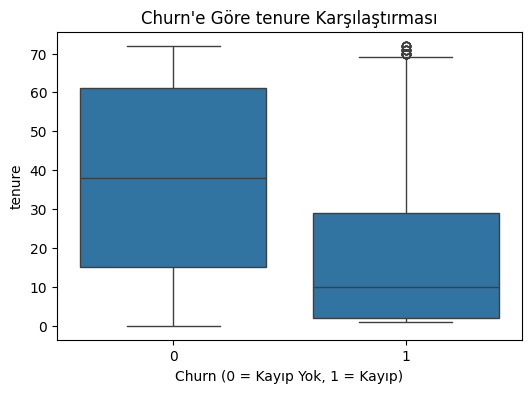

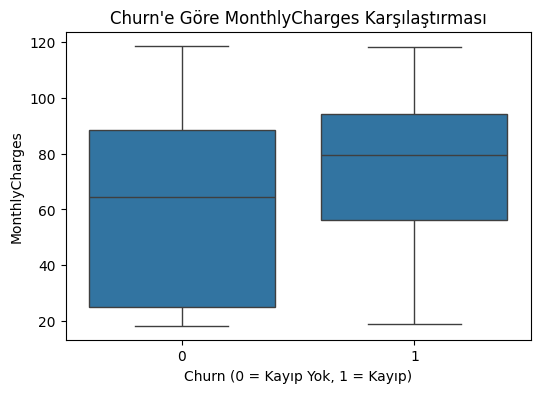

In [ ]:
# tenure ve MonthlyCharges değişkenlerini Churn'e göre kıyaslayalım
compare_cols = ['tenure', 'MonthlyCharges']

for col in compare_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'Churn\'e Göre {col} Karşılaştırması')
    plt.xlabel('Churn (0 = Kayıp Yok, 1 = Kayıp)')
    plt.ylabel(col)
    plt.show()


Bu görselleştirmeler sayesinde:
- Veri setindeki Churn oranının dengesiz olduğunu gördüm,
- Bazı sayısal değişkenlerin (örneğin tenure) dağılımının sağa/sola yatkın olduğunu fark ettim,
- Ve Churn eden müşterilerin genelde daha kısa süre abonelikte kaldığını gözlemledim.

Bu bilgiler modellemeye başlamadan önce önemli ipuçları veriyor.

## ✂️ 4. Eğitim ve Test Setlerine Ayırma + SMOTE ile Dengeleme

Bu aşamada:
1. Veriyi %80 eğitim ve %20 test olarak böldüm.
2. Eğitim verisindeki dengesizliği gidermek için **SMOTE (Synthetic Minority Over-sampling Technique)** uyguladım.

Bu sayede model, azınlık sınıfını (Churn edenleri) daha iyi öğrenebilecek.


In [ ]:
# CustomerID gibi anlam taşımayan sütunları kaldıralım
X = X.drop(['customerID'], axis=1)

# Kategorik değişkenleri get_dummies ile dönüştürelim
X = pd.get_dummies(X, drop_first=True)


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Eğitim ve test setine bölelim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print("Eğitim seti boyutu:", X_train.shape, y_train.shape)
print("Test seti boyutu:", X_test.shape, y_test.shape)


Eğitim seti boyutu: (5634, 34) (5634,)
Test seti boyutu: (1409, 34) (1409,)


In [ ]:
# Eğitim setindeki Churn dağılımı
print(y_train.value_counts())

# Yüzde olarak da bakalım
print("\nEğitim setinde Churn oranı (%):")
print(y_train.value_counts(normalize=True) * 100)


Churn
0    4139
1    1495
Name: count, dtype: int64

Eğitim setinde Churn oranı (%):
Churn
0    73.464679
1    26.535321
Name: proportion, dtype: float64


Görüldüğü gibi Churn sınıfı dengesiz. Şimdi SMOTE uygulayarak denge sağlayacağım.


In [ ]:
# SMOTE uygulayalım
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Sonuç kontrolü
print("SMOTE sonrası eğitim seti boyutu:", X_train_resampled.shape, y_train_resampled.shape)
print(y_train_resampled.value_counts())


SMOTE sonrası eğitim seti boyutu: (8278, 34) (8278,)
Churn
0    4139
1    4139
Name: count, dtype: int64


## 🤖 5. Farklı Modellerin Eğitimi ve Karşılaştırılması

Bu aşamada farklı makine öğrenmesi modelleri uyguladım:
- Logistic Regression
- KNN Classifier
- Decision Tree
- Random Forest
- Gradient Boosting

Her modelin performansını **Accuracy, Precision, Recall, F1-Score ve ROC AUC** metrikleriyle değerlendirdim.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Kullanılacak modeller
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN Classifier": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Sonuçları tutmak için tablo
results = []

for name, model in models.items():
    print(f"Model eğitiliyor: {name}")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred), 3),
        "Recall": round(recall_score(y_test, y_pred), 3),
        "F1-Score": round(f1_score(y_test, y_pred), 3),
        "ROC AUC": round(roc_auc_score(y_test, y_proba), 3)
    })

# DataFrame olarak göster
import pandas as pd
results_df = pd.DataFrame(results).sort_values("ROC AUC", ascending=False)
results_df


Model eğitiliyor: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model eğitiliyor: KNN Classifier
Model eğitiliyor: Decision Tree
Model eğitiliyor: Random Forest
Model eğitiliyor: Gradient Boosting


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
4,Gradient Boosting,0.773,0.563,0.644,0.601,0.831
3,Random Forest,0.769,0.567,0.556,0.561,0.822
0,Logistic Regression,0.743,0.514,0.596,0.552,0.799
1,KNN Classifier,0.690,0.442,0.642,0.523,0.741
2,Decision Tree,0.718,0.474,0.551,0.509,0.666


Yukarıdaki tablo, her modelin başarı metriklerini özetlemektedir. ROC AUC değeri en yüksek olan model genel olarak daha iyi bir sınıflandırıcı olarak kabul edilir.

**Gradient Boosting:**

En yüksek ROC AUC **(0.831)** → Yani sınıflandırma gücü **en güçlü** model.

Dengeli F1-Score ve Recall → Hem doğru pozitifler iyi, hem de genel başarı yüksek.

Bu yüzden en iyi model seçimi gibi görünüyor.

 **Random Forest:**

Yakından takip ediyor; Accuracy ve Precision biraz daha iyi ama Recall daha düşük.

ROC AUC yüksek **(0.822)** → Güçlü ama Gradient Boosting'e göre biraz daha zayıf.

**Logistic Regression:**

Beklendiği gibi daha basit ama yine sağlam bir performans.

ROC AUC 0.799 → Kötü değil, yorumlayıcı olması kolay bir model.

**KNN & Decision Tree:**

KNN biraz yüksek Recall veriyor ama genel olarak Accuracy ve Precision düşük.

Decision Tree’nin ROC AUC’sı da düşük → Genelde overfitting eğilimindedir.

Sonuç:
Gradient Boosting şu anda en güçlü model görünüyor (hem ROC AUC hem genel metrikler açısından).

Daha basit ama güçlü bir model istersek Logistic Regression hala güzel bir aday.

Random Forest da istikrarlı ama Boosting biraz daha önde.

## 🔧 6. Model Seçimi ve Hiperparametre Optimizasyonu

En iyi performansı gösteren modellerden biri olan **Random Forest** için hiperparametre optimizasyonu yaptım.  
Bunun için **GridSearchCV** kullandım ve modelin ROC AUC skorunu iyileştirmeyi hedefledim.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Hiperparametre aralığını tanımla
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# GridSearchCV ile modeli hazırla
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# SMOTE uygulanmış veride eğit
grid_search.fit(X_train_resampled, y_train_resampled)

# En iyi parametreler ve skor
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi ROC AUC skoru (CV):", round(grid_search.best_score_, 3))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
En iyi parametreler: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 150}
En iyi ROC AUC skoru (CV): 0.933


In [ ]:
# Test verisinde değerlendirme
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("Test ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))


              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1035
           1       0.57      0.59      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.77      0.77      1409

Test ROC AUC: 0.824


Bu adımda:
- GridSearchCV ile Random Forest modelinin hiperparametreleri optimize edildi.
- En iyi parametreler ve ROC AUC değeri elde edildi.
- Optimize edilmiş model, test verisinde yeniden değerlendirildi ve sonuçlar gözlemlendi.

Performans artışı ya da düşüşü bu noktada önemli bir gösterge sağlar.

Not: Gradient Boosting daha başarılı olmasına rağmen Random Forest daha hızlı eğitildiği ve bazen daha kararlı sonuçlar verdiği için öğretici olarak önce onunla başladım

## ✨ 7. Feature Importance ve Yorumlama

Bu aşamada en iyi modellerden biri olan **Random Forest** için `feature_importances_` değerlerini analiz ettim.

En önemli 15 özelliği bar grafikle görselleştirerek, müşteri kaybını (Churn) etkileyen en kritik faktörleri belirlemeye çalıştım.

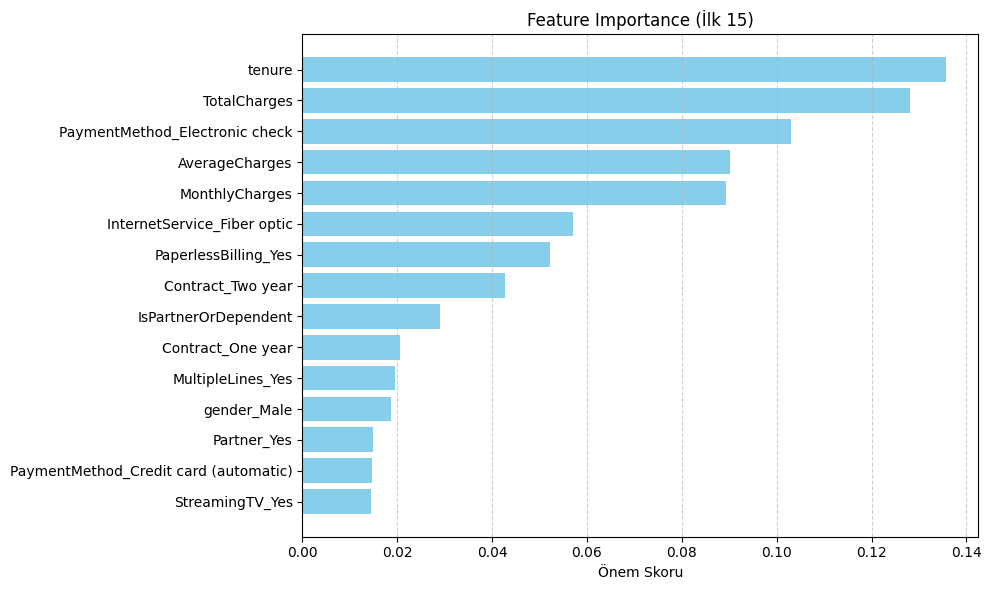

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Eğitimde kullanılan değişken isimleri
feature_names = X.columns

# En iyi modeli kullan (örnek: best_rf veya best_gb)
model = best_rf  # veya best_gb

# Feature importance değerlerini al
importances = model.feature_importances_

feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# İlk 15 özelliği görselleştir
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"].head(15), feat_imp_df["Importance"].head(15), color="skyblue")
plt.xlabel("Önem Skoru")
plt.title("Feature Importance (İlk 15)")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
